## Notebook for Running Experiments on CovType Data Set

In [1]:
#%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [84]:
from labellines import labelLines

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.base_experiment import Experiment
from test_harness.experiments.experiment_container import ExperimentContainer
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)



## Load Data

In [3]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

In [4]:
# with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
#     drift_df = pickle.load(f)

## Experiments

### Prepare Test Harness

In [5]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

In [6]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

In [7]:
max_comp_num = drift_df.shape[1]

#### EDA on dataset

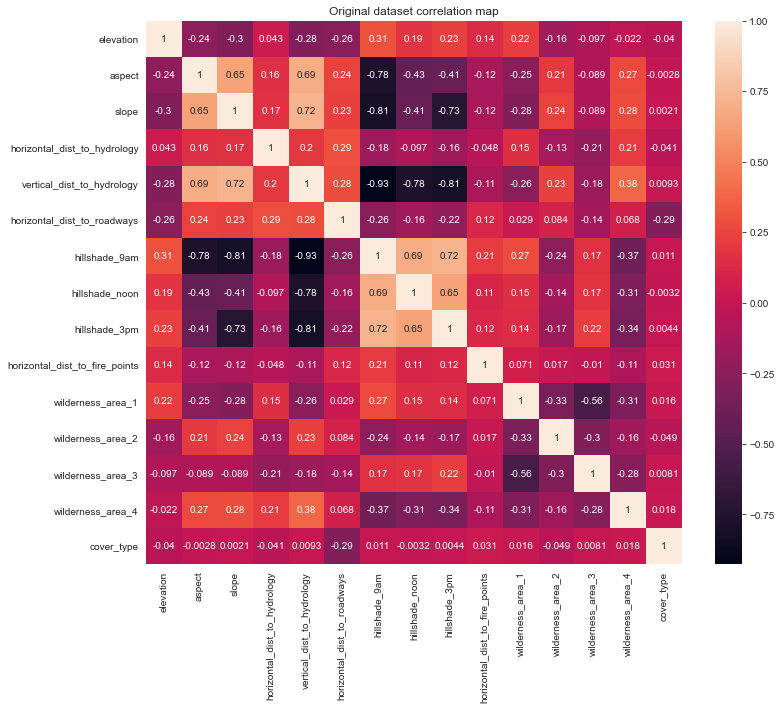

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=True)

plt.title('Original dataset correlation map')
plt.show()

## Run Experiments

### PCA dataset experiments

#### Create PCA reduced datasets

In [87]:
experiments = ExperimentContainer()

In [88]:
model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

In [89]:
column_mapping_pca = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

In [90]:
drift_df_scaled = pd.DataFrame(StandardScaler().fit_transform(drift_df.drop(column_mapping_pca['target'], axis=1)), columns=drift_df.columns[:-1])
drift_df_scaled[column_mapping_pca['target']] = drift_df[column_mapping_pca['target']]

In [91]:
for comp_num in range(2, max_comp_num):
    experiments.add_dataset(comp_num, Dataset(full_df=drift_df_scaled, column_mapping=column_mapping, window_size=17500 * 2, pca=True, pca_dim=comp_num))

Adding 2 dim. PCA dataset
Adding 3 dim. PCA dataset
Adding 4 dim. PCA dataset
Adding 5 dim. PCA dataset
Adding 6 dim. PCA dataset
Adding 7 dim. PCA dataset
Adding 8 dim. PCA dataset
Adding 9 dim. PCA dataset
Adding 10 dim. PCA dataset
Adding 11 dim. PCA dataset
Adding 12 dim. PCA dataset
Adding 13 dim. PCA dataset
Adding 14 dim. PCA dataset


In [92]:
for pca_dim, _dataset in experiments.dataset_container.items():

    print(f'PCA dim: {pca_dim}')

    print(f'BaselineExperiment')
    baseline = BaselineExperiment(model=model, dataset=_dataset, param_grid=param_grid, pca=True)
    baseline.run()
    experiments.add_model_iteration(baseline, 'BaselineExperiment')

    print(f'ToplineExperiment')
    topline = ToplineExperiment(model=model, dataset=_dataset, k=10, param_grid=param_grid, pca=True)
    topline.run()
    experiments.add_model_iteration(topline, 'ToplineExperiment')

    print(f'UncertaintyKSExperiment')
    uncertainty_ks = UncertaintyKSExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, significance_thresh=0.001, pca=True)
    uncertainty_ks.run()
    experiments.add_model_iteration(uncertainty_ks, 'UncertaintyKSExperiment')

    print(f'UncertaintyX2Experiment')
    uncertainty_x2 = UncertaintyX2Experiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, significance_thresh=0.001, margin_width=0.1, pca=True)
    uncertainty_x2.run()
    experiments.add_model_iteration(uncertainty_x2, 'UncertaintyX2Experiment')

    print(f'MarginThresholdExperiment_v1')
    margin_threshold_1 = MarginThresholdExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, margin_width=0.1, sensitivity=1, pca=True)
    margin_threshold_1.run()
    experiments.add_model_iteration(margin_threshold_1, 'MarginThresholdExperiment_v1')

    print(f'MarginThresholdExperiment_v2\n')
    margin_threshold_2 = MarginThresholdExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, margin_width=0.1, sensitivity=2, pca=True)
    margin_threshold_2.run()
    experiments.add_model_iteration(margin_threshold_2, 'MarginThresholdExperiment_v2')

    experiments.add_model(pca_dim)

PCA dim: 2
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 3
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 4
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 5
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 6
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 7
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 8
BaselineExperiment
ToplineExperiment
UncertaintyKSExperimen

## Plot Experimental Results

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line7), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line8), but could not find a label for it.
  warnings.warn(


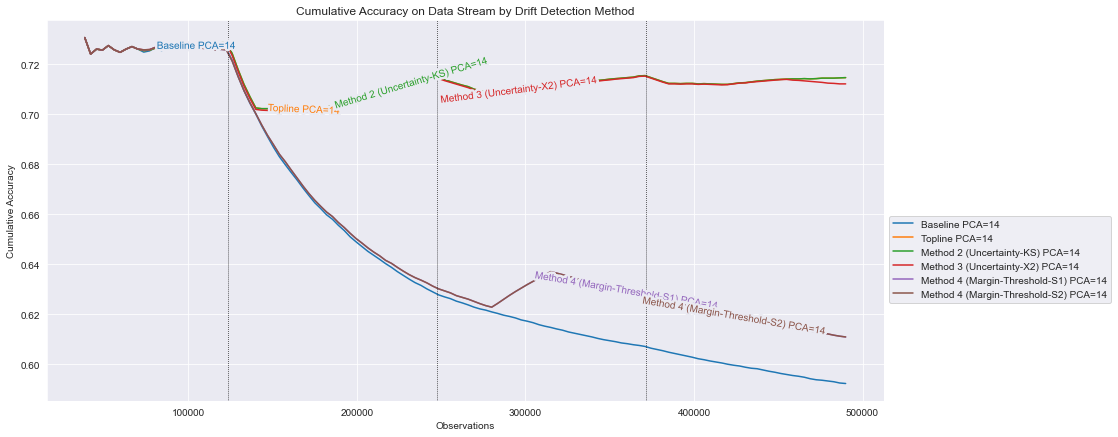

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
Baseline,0,0,0,0,0.0707,0.5924,0.16
Topline,13,3,10,0,0.9896,0.7146,2.26
Method 2 (Uncertainty-KS),13,3,10,0,0.9896,0.7146,2.23
Method 3 (Uncertainty-X2),10,6,4,0,0.7776,0.7121,1.75
Method 4 (Margin-Threshold-S1),1,11,0,10,0.1414,0.6110,0.32
Method 4 (Margin-Threshold-S2),1,11,0,10,0.1414,0.6110,0.32


In [93]:
exps = []
pca_dim_plotting = 14

for k in experiments.model_container[pca_dim_plotting].keys():
    exps.append(experiments.model_container[pca_dim_plotting][k])

plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


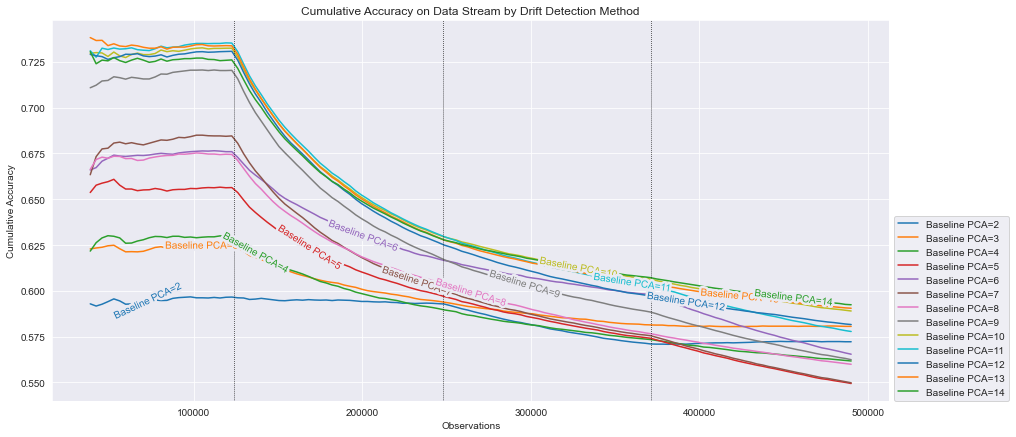

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


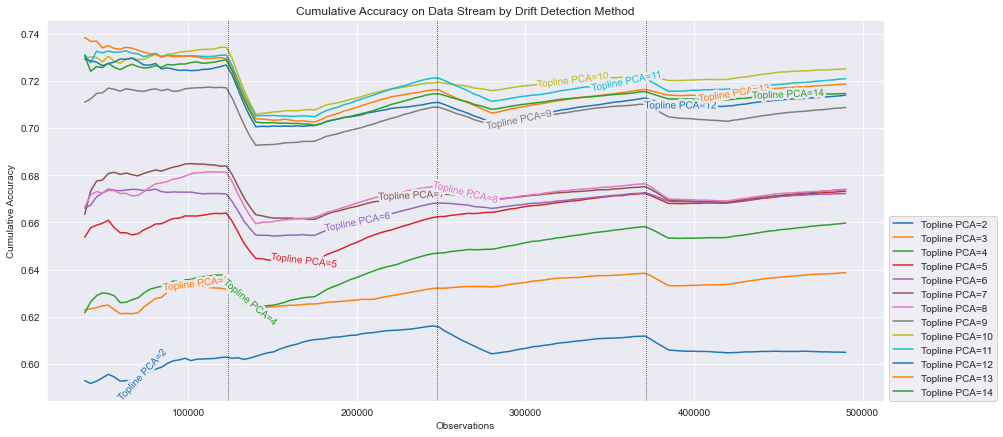

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


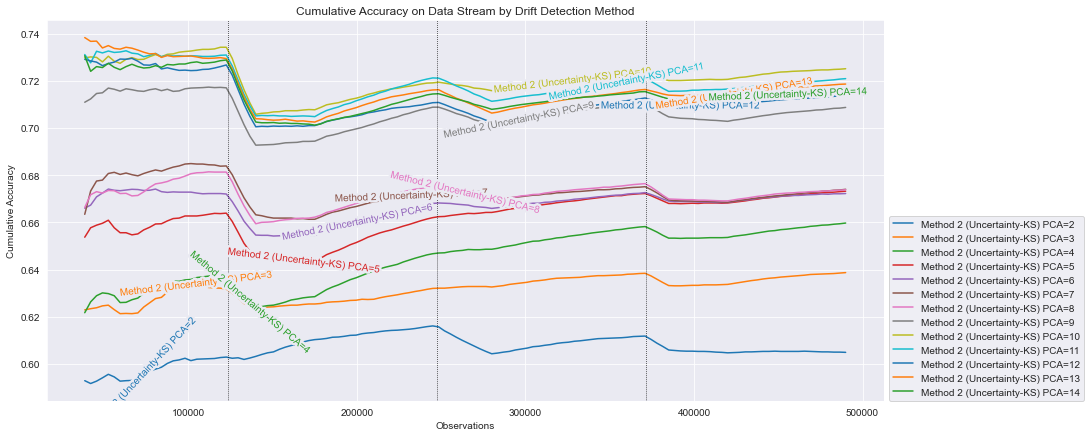

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


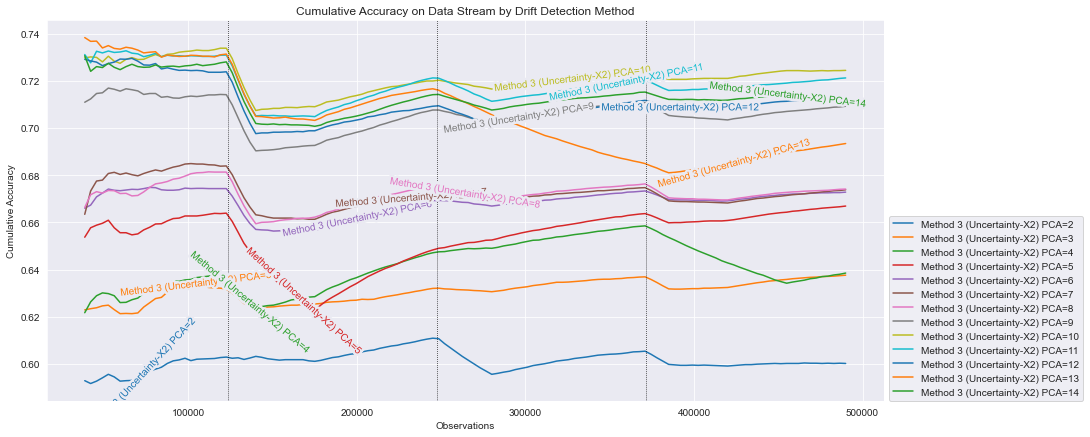

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


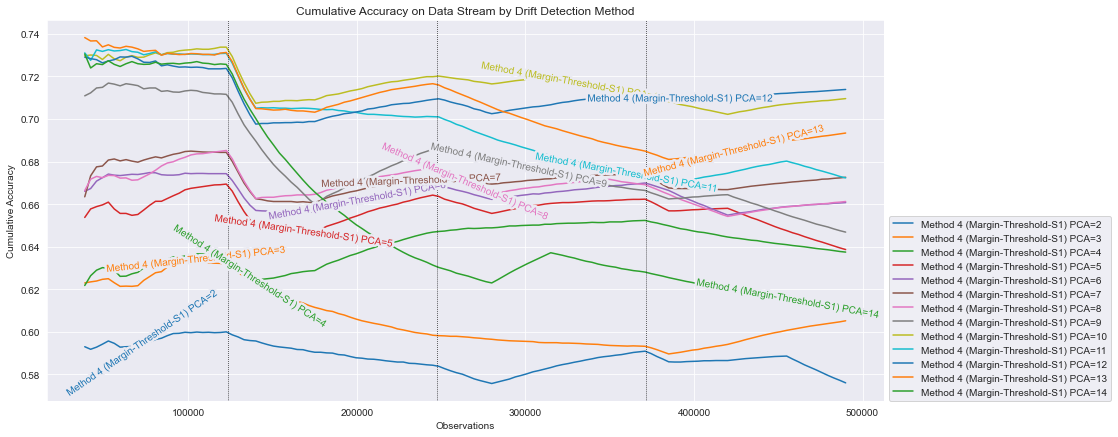

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line13), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line14), but could not find a label for it.
  warnings.warn(
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line15), but could not find a label for it.
  warnings.warn(


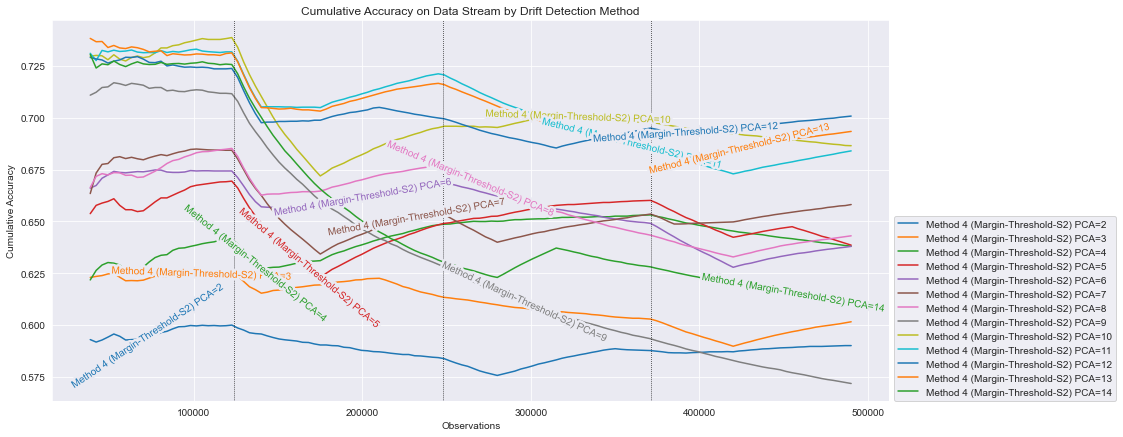

In [94]:
exps = []

for k in experiments.model_container[2].keys():
    for dim in range(2, 15):
        exps.append(experiments.model_container[dim][k])

    plot_multiple_experiments(exps, change_points)
    exps = []
#aggregate_experiment_metrics(exps)

#### Single experiments

In [95]:
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

In [96]:
# baseline experiment
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run(sliding_eval=True, sliding_window=100000, sliding_step=5000)

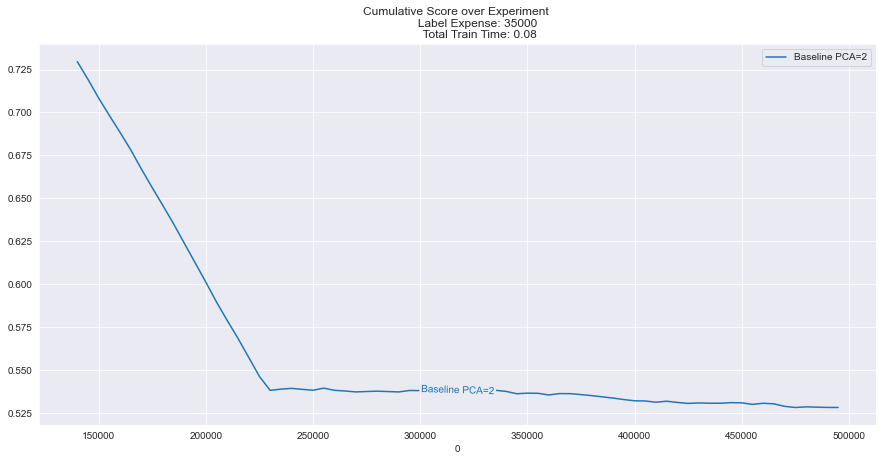

In [97]:
plot_experiment_error(baseline)

#### Analysing PCA datasets

In [14]:
print(experiments.dataset_container[2].explained_variance_absolutes)

[5.08254202 1.80619914]


In [15]:
experiments_pca_tests = ExperimentContainer()

for comp_num in range(2, 15):
    experiments_pca_tests.add_dataset(comp_num, Dataset(full_df=drift_df_scaled, column_mapping=column_mapping, window_size=17500 * 2, pca=True, pca_dim=comp_num))

Adding 2 dim. PCA dataset
Adding 3 dim. PCA dataset
Adding 4 dim. PCA dataset
Adding 5 dim. PCA dataset
Adding 6 dim. PCA dataset
Adding 7 dim. PCA dataset
Adding 8 dim. PCA dataset
Adding 9 dim. PCA dataset
Adding 10 dim. PCA dataset
Adding 11 dim. PCA dataset
Adding 12 dim. PCA dataset
Adding 13 dim. PCA dataset
Adding 14 dim. PCA dataset


#### Get feature rankings

In [16]:
result_storage = {}

In [17]:
all_features = CT_dataset.full_df.columns[:-1]

In [18]:
for pc_num, dataset in experiments_pca_tests.dataset_container.items():
    orders_per_component = dataset.components_features_all

    feature_rankings = pd.DataFrame()
    feature_rankings['PC'] = orders_per_component[0].values

    for feat in all_features:
        feat_ranking_vals = []

        for i in range(len(orders_per_component)):
            feat_ranking_vals.append(orders_per_component.at[i, 1].index(feat) + 1)

        feature_rankings[feat] = feat_ranking_vals

    result_storage[pc_num] = feature_rankings

In [124]:
result_storage[5]

,PC,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4
0,PC0,8,5,3,12,2,9,1,6,4,14,10,11,13,7
1,PC1,4,11,10,3,13,5,14,12,9,8,1,6,2,7
2,PC2,7,12,10,6,14,5,11,9,13,3,8,1,4,2
3,PC3,3,10,14,2,11,1,13,7,8,6,12,5,4,9
4,PC4,2,14,13,10,5,12,9,6,11,1,4,7,8,3


In [38]:
mean_df = pd.DataFrame()
std_df = pd.DataFrame()

In [39]:
for i in range(2, max_comp_num):
    mean_df[f'mean_{i}'] = np.mean(result_storage[i])
    std_df[f'std_{i}'] = np.std(result_storage[i])

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [40]:
mean_df

,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,mean_11,mean_12,mean_13,mean_14
elevation,6.0,6.333333,5.50,4.8,6.333333,5.571429,6.125,6.222222,5.8,6.181818,6.666667,7.000000,7.214286
aspect,8.0,9.333333,9.50,10.4,10.666667,9.714286,8.625,8.111111,8.0,7.545455,7.250000,7.692308,7.714286
slope,6.5,7.666667,9.25,10.0,10.500000,9.714286,9.000,8.222222,7.9,7.272727,7.166667,6.846154,6.714286
horizontal_dist_to_hydrology,7.5,7.000000,5.75,6.6,6.333333,5.857143,5.500,5.555556,5.4,6.181818,6.583333,6.538462,6.857143
vertical_dist_to_hydrology,7.5,9.666667,10.00,9.0,9.000000,9.714286,10.250,10.222222,10.1,9.636364,8.916667,8.384615,8.214286
horizontal_dist_to_roadways,7.0,6.333333,5.00,6.4,7.000000,7.142857,7.875,7.111111,6.5,6.545455,6.666667,7.230769,7.714286
hillshade_9am,7.5,8.666667,9.75,9.6,9.833333,9.714286,10.000,9.888889,10.1,9.727273,9.083333,8.461538,8.500000
hillshade_noon,9.0,9.000000,8.50,8.0,7.333333,7.285714,6.625,6.444444,6.4,6.181818,5.916667,6.384615,6.857143
hillshade_3pm,6.5,8.666667,8.50,9.0,8.833333,9.142857,8.750,8.111111,7.6,7.090909,6.916667,6.692308,6.714286
horizontal_dist_to_fire_points,11.0,8.333333,7.75,6.4,6.333333,7.142857,7.625,7.666667,7.7,8.181818,8.083333,7.846154,8.142857


In [41]:
std_df

,std_2,std_3,std_4,std_5,std_6,std_7,std_8,std_9,std_10,std_11,std_12,std_13,std_14
elevation,2.0,1.699673,2.061553,2.315167,4.027682,4.169863,4.166458,3.937788,3.944617,3.950102,4.109609,4.113767,4.038716
aspect,3.0,3.091206,2.692582,3.006659,2.808717,3.493434,4.357106,4.357483,4.147288,4.207431,4.145781,4.267671,4.113194
slope,3.5,3.299832,3.960745,3.847077,3.685557,3.917517,4.123106,4.466611,4.346263,4.594283,4.412734,4.382591,4.249850
horizontal_dist_to_hydrology,4.5,3.741657,3.897114,3.878144,3.590110,3.522522,3.427827,3.235604,3.104835,3.856946,3.925522,3.774721,3.814580
vertical_dist_to_hydrology,5.5,5.436502,4.743416,4.690416,4.281744,4.333072,4.293891,4.049082,3.858756,3.960549,4.480668,4.682840,4.554097
horizontal_dist_to_roadways,2.0,1.885618,2.828427,3.773592,3.696846,3.440456,3.756245,4.148479,4.341659,4.142104,3.986087,4.299443,4.494895
hillshade_9am,6.5,5.557777,5.165995,4.630335,4.258977,3.953815,3.774917,3.572874,3.448188,3.492613,3.967752,4.378538,4.221543
hillshade_noon,3.0,2.449490,2.291288,2.280351,2.560382,2.373321,2.825664,2.712568,2.576820,2.551940,2.596739,2.975243,3.335034
hillshade_3pm,2.5,3.681787,3.201562,3.033150,2.793842,2.695423,2.727178,3.142697,3.352611,3.579094,3.475110,3.428043,3.304295
horizontal_dist_to_fire_points,3.0,4.496913,4.023369,4.498889,4.109609,4.290474,4.211220,3.972125,3.769615,3.903802,3.751851,3.697112,3.719776


In [70]:
x_s = [i for i in range(2, max_comp_num)]

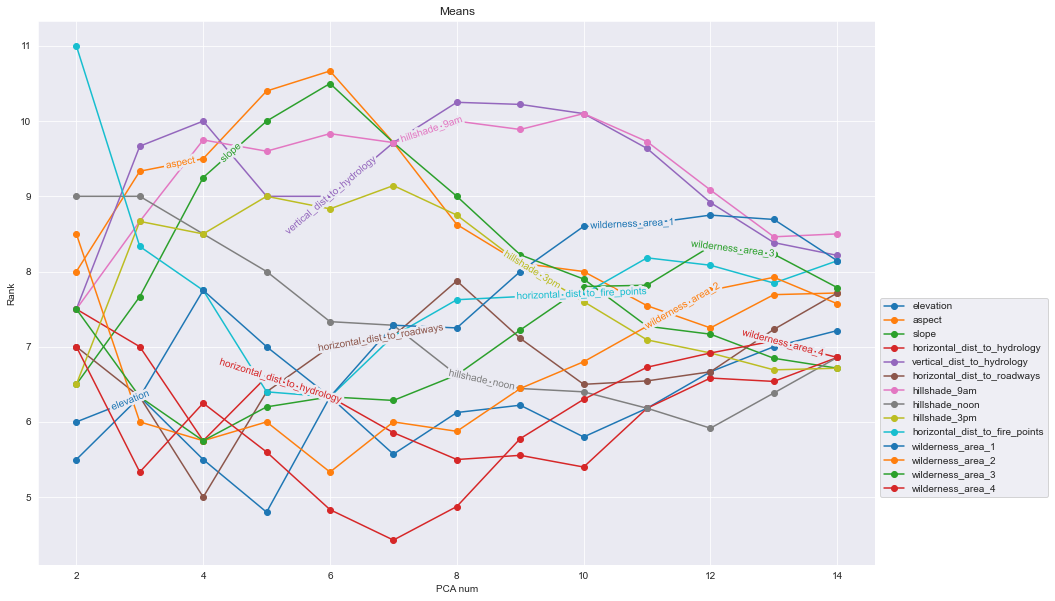

In [125]:
plt.figure(figsize=(15,10))
for col in all_features:
    plt.plot(x_s, mean_df.loc[col], marker='o', label=col)

plt.legend(bbox_to_anchor=(1, 0.5))
labelLines(plt.gca().get_lines(), align=True)
plt.title(f'Means')
plt.xlabel('PCA num')
plt.ylabel('Rank')
plt.show()

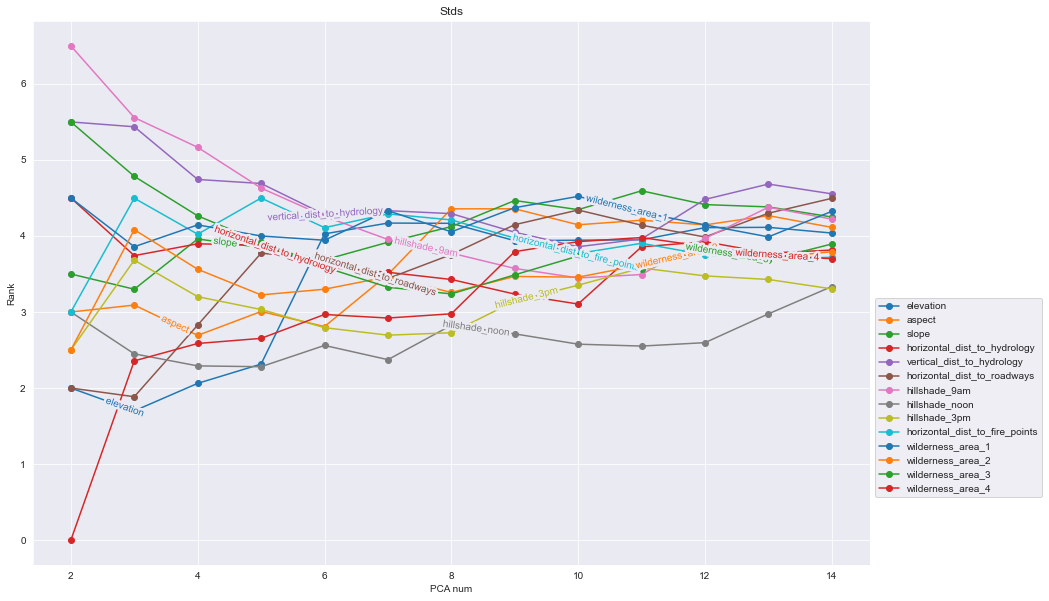

In [126]:
plt.figure(figsize=(15,10))
for col in all_features:
    plt.plot(x_s, std_df.loc[col], marker='o', label=col)

plt.legend(bbox_to_anchor=(1, 0.5))
labelLines(plt.gca().get_lines(), align=True)
plt.title(f'Stds')
plt.ylabel('Rank')
plt.xlabel('PCA num')
plt.show()

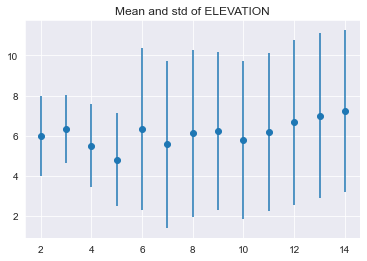

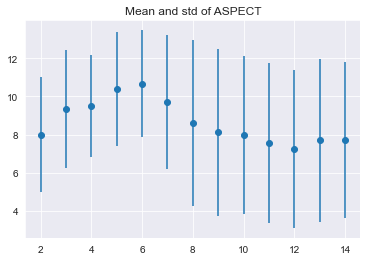

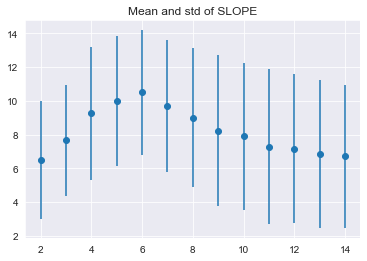

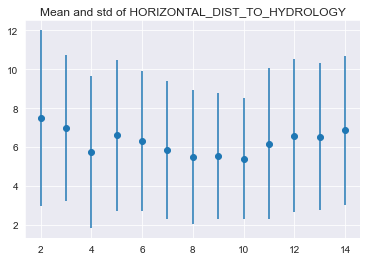

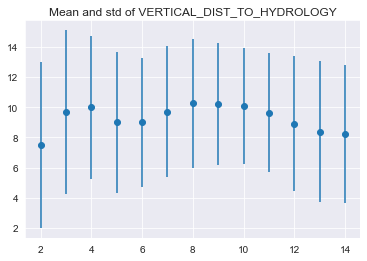

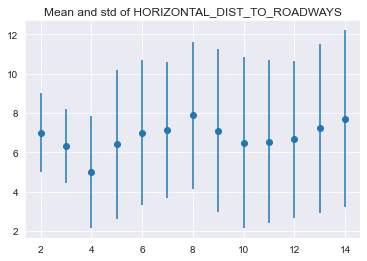

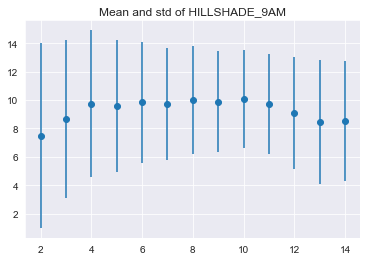

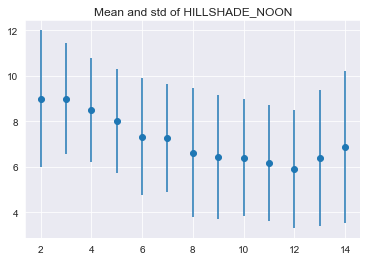

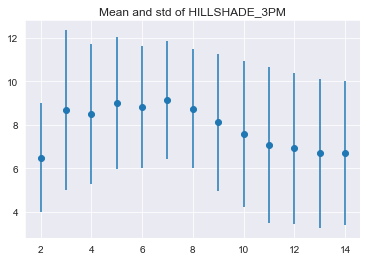

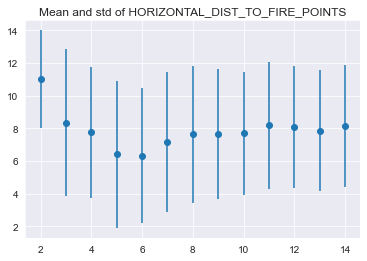

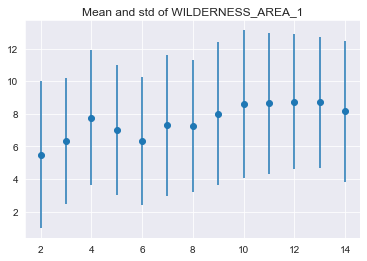

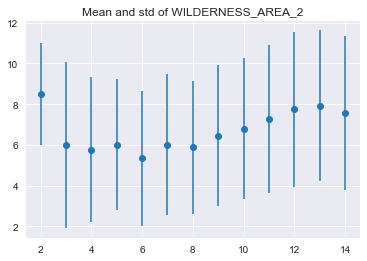

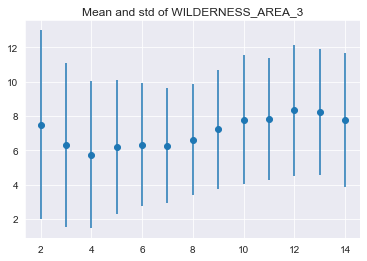

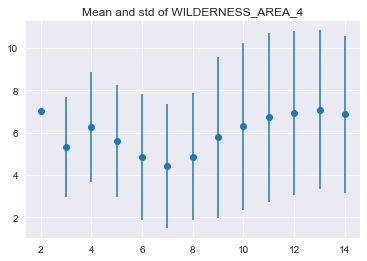

In [76]:
for col in all_features:
    plt.errorbar(x_s, mean_df.loc[col], std_df.loc[col], fmt='o')
    plt.title(f'Mean and std of {col.upper()}')
    plt.show()

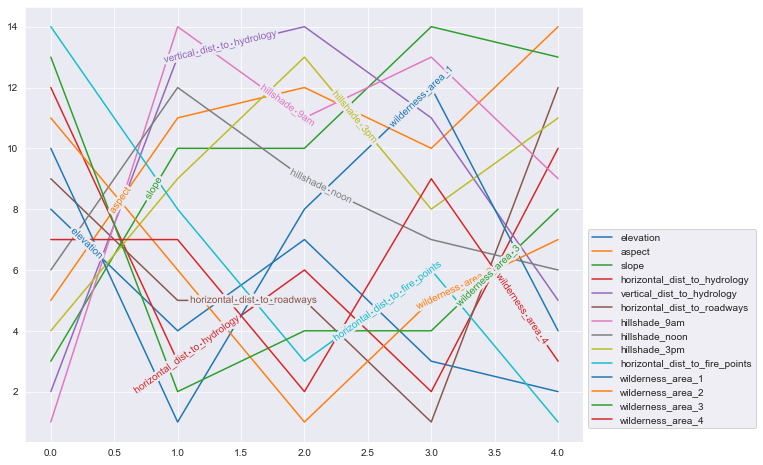

In [86]:
result_storage[5].plot(figsize=(10, 8))
plt.legend(bbox_to_anchor=(1, 0.5))
labelLines(plt.gca().get_lines(), align=True)
plt.show()